In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

%matplotlib inline

loss        0.007107
val_loss    0.045334
dtype: float64


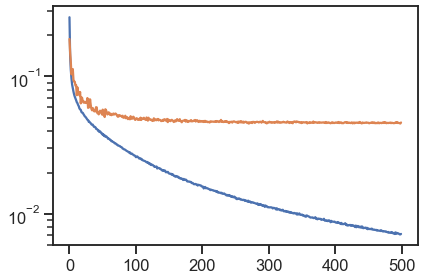

In [3]:
log = pd.read_csv('20210208_redox_model/log.csv').set_index('epoch')

plt.semilogy(log.loss)
plt.semilogy(log.val_loss)

print(log.min())

plt.tight_layout()
# plt.xlim([0, 10])

In [ ]:
from preprocessor import preprocessor

from loss import AtomInfMask, KLWithLogits, RedoxAttention
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate
import tensorflow_addons as tfa

model = tf.keras.models.load_model(
    '20210208_redox_model/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'EdgeUpdate': EdgeUpdate,
                       'NodeUpdate': NodeUpdate,
                       'GlobalUpdate': GlobalUpdate}})

new_model = tf.keras.Model(model.inputs[:3], model.outputs)

In [5]:
redox_new_calcs = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/20210109_dft_ml_redox_data.csv.gz')
data = np.load('redox_split.npz', allow_pickle=True)

In [8]:
redox_valid = redox_new_calcs[redox_new_calcs.smiles.isin(data['test_new'])]

test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in redox_valid.smiles),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

In [16]:
predicted_redox = new_model.predict(test_dataset, verbose=1)

4/4 [==============================] - 0s 70ms/step


Text(0.5, 1.0, 'electron affinity')

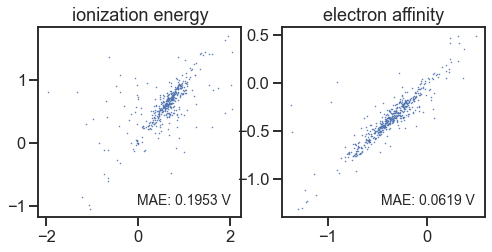

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3.5))
axs[0].plot(redox_valid['ionization energy'], predicted_redox[:, 0], '.', ms=1)
axs[1].plot(redox_valid['electron affinity'], predicted_redox[:, 1], '.', ms=1)

axs[0].text(.95, .05, f"MAE: {(redox_valid['ionization energy'] - predicted_redox[:, 0]).abs().mean():.4f} V", ha='right', va='bottom', transform=axs[0].transAxes, fontsize=14)
axs[1].text(.95, .05, f"MAE: {(redox_valid['electron affinity'] - predicted_redox[:, 1]).abs().mean():.4f} V", ha='right', va='bottom', transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('ionization energy')
axs[1].set_title('electron affinity')

In [18]:
new_model.save('/projects/rlmolecule/pstjohn/models/20210208_redox_model/', include_optimizer=False)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /projects/rlmolecule/pstjohn/models/20210208_redox_model/assets
